### Enhancing data


When running `pre_et_look`, on some variables extra functions are applied. In this notebook we'll take a closer look at those functions and how to modify them.

First we install pywapor, in case it's not installed yet.

In [ ]:
!pip install pywapor==2.4.1 --quiet

And define the usual parameters.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
startdate = "2021-07-01"
enddate = "2021-07-11"

There are two moments at which these extra functions can be applied, before and after the composites have been calculated. We can check the functions that get applied before the compositer like this.

In [2]:
source_enhancements = pywapor.general.pre_defaults.source_enhancements_defaults()

`source_enhancements` is a dictionary, with the following keys.

In [3]:
list(source_enhancements.keys())

[('MERRA2', 't_air_24'),
 ('MERRA2', 't_air_min_24'),
 ('MERRA2', 't_air_max_24'),
 ('GEOS5', 't_air_24'),
 ('GEOS5', 't_air_min_24'),
 ('GEOS5', 't_air_max_24'),
 ('GLOBCOVER', 'lulc'),
 ('WAPOR', 'lulc')]

As you can see, the keys specify not only variables, but also their sources. Meaning these source enhancements are applied to variables stemming from specific source. This means, for example, that you can choose to apply a function only to `ndvi` coming from Landsat, and not to `ndvi` coming from MODIS etc.

Now let's have a look at some of the values in the dictionary.

In [4]:
source_enhancements[('GEOS5','t_air_24')]

[<function pywapor.enhancers.temperature.kelvin_to_celsius(ds, var, out_var=None)>]

As you can see, the value for `t_air_24` from `GEOS5` is a list (with length 1) that contains a function called `kelvin_to_celsius`. This means that, by default, this function is applied to all `t_air_24` data coming from `MERRA2`, before the `t_air_24` composite is calculated. 

This is important because `et_look` needs `t_air_24` to be degrees Celcius. It also important that this conversion happens before the calculation of the composite, because if we would select multiple sources for this variable, it's important they all have the same unit before combining them in a composite!

Now let's have a look at the functions that get applied by default to the variables after the composites have been calculated.

In [5]:
composite_enhancements = pywapor.general.pre_defaults.composite_enhancements_defaults()
list(composite_enhancements.keys())

['t_air_24', 't_air_min_24', 't_air_max_24', 'z']

As you see, now the keys are just simple strings defining some variables that will have some extra function applied to them (instead of the tuples of two strings we saw before for `source_enhancements`).

In [6]:
composite_enhancements['t_air_24']

[<function pywapor.enhancers.temperature.lapse_rate(ds, var, out_var=None, lapse_var='z', radius=0.25, lapse_rate=-0.006)>]

Here you can see that after the composites for `t_air_24` have been calculated, another "enhancement" called `lapse_rate` is applied to it. This function applies a correction to the temperatures based on the difference between the local and local-mean altitude.

Before we start adjusting the default enhancers, let's first do a `pre_et_look` to have a point of reference. Instead of running `pre_et_look` for all variables, we will only process `ndvi`, `t_air_24` and `z` in order to save some time (i.e. the output will thus not be sufficient to run `et_look`) by passing a keyword argument called `process_vars`. 

In [7]:
    process_vars = ["ndvi", "t_air_24", "z"]
    ds, fh = pywapor.pre_et_look.main(project_folder, startdate, 
                                            enddate, latlim, lonlim, 
                                            process_vars = process_vars)


> PRE_ET_LOOK
    # ndvi
    --> Downloading MOD13.
Tile: 3 / 3: 0.00Bytes [00:00, ?Bytes/s]
    --> Downloading MYD13.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
    --> Resampling resolution is ~205 meter.
    --> Resampling datasets.
    --> Calculating composites.
    # t_air_24
    --> Downloading GEOS5 (daily), t2m.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
    --> Applying 'kelvin_to_celsius' to `t_air_24` from GEOS5.
    --> Resampling datasets.
    --> Calculating composites.
    # z
    --> Downloading SRTM.
    --> Resampling datasets.
    > Composite enhancers.
        # t_air_24
        --> Calculating local means (r = 0.25°) of `z`.
        --> Applying 'lapse_rate' to `t_air_24`.
        # z
        --> Creating new variable `slope`.
        --> Creating new variable `aspect`.
        --> Creating new variable `lat_deg`.
        --> Creating new variable `lon_deg`.
    < Composite enhancers.
    --> Saving results.
< PRE_ET_LOOK


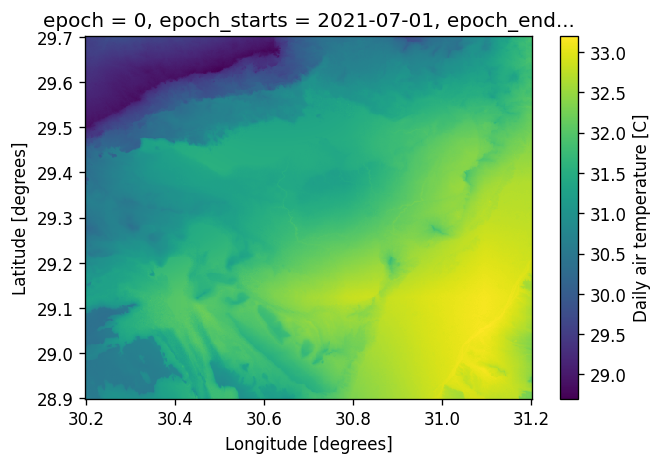

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(1)
fig.set_dpi(120)
ds.t_air_24.isel(epoch=0).plot(ax = fig.gca())

Notice how `t_air_24` is given in degrees Celcius and that the altitude is clearly visible in the map (make a plot of `z` by yourself to compare!).

Now let's do a run where we turn of the `lapse_rate` correction for `t_air_24`. We can simply override the composite enhancements for `t_air_24` by passing it an empty list.

In [9]:
extra_composite_enhancements = {'t_air_24': []}

In [10]:
ds, fh = pywapor.pre_et_look.main(project_folder, startdate, 
                                        enddate, latlim, lonlim, 
                                        process_vars = process_vars,
                                        extra_composite_enhancements = extra_composite_enhancements)

> PRE_ET_LOOK
    # ndvi
    --> Downloading MOD13.
Tile: 3 / 3: 0.00Bytes [00:00, ?Bytes/s]
    --> Downloading MYD13.
Tile: 1 / 1: 0.00Bytes [00:00, ?Bytes/s]
    --> Resampling resolution is ~205 meter.
    --> Resampling datasets.
    --> Calculating composites.
    # t_air_24
    --> Downloading GEOS5 (daily), t2m.
Tile: 11 / 11: 0.00Bytes [00:00, ?Bytes/s]
    --> Applying 'kelvin_to_celsius' to `t_air_24` from GEOS5.
    --> Resampling datasets.
    --> Calculating composites.
    # z
    --> Downloading SRTM.
    --> Resampling datasets.
    > Composite enhancers.
        # t_air_24
        # z
        --> Creating new variable `slope`.
        --> Creating new variable `aspect`.
        --> Creating new variable `lat_deg`.
        --> Creating new variable `lon_deg`.
    < Composite enhancers.
    --> Saving results.
< PRE_ET_LOOK


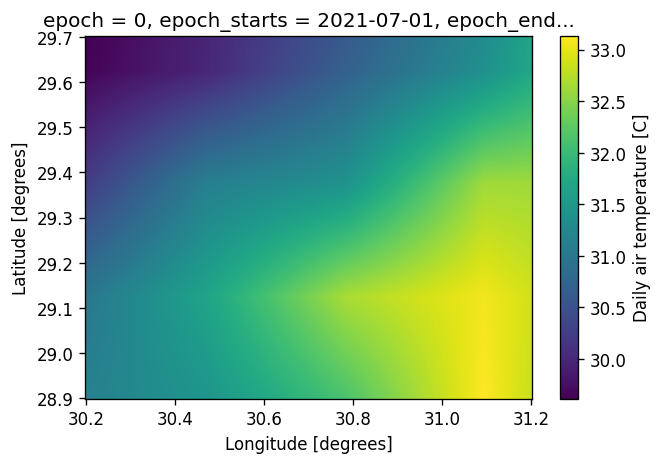

In [11]:
fig = plt.figure(1)
fig.set_dpi(120)
ds.t_air_24.isel(epoch=0).plot(ax = fig.gca())

Notice that the temperature is still given in degrees Celcius, but is much smoother now compared to the temperature map with the `lapse_rate` correction we saw above.

#### Gap-filling

Now let's see how to implement your own functions. The Landsat-7 scene we used in the previous notebook had many stripes of missing data. Here we are going to write a function that fills up these lines and ingest that function into `pre_et_look`. Lets first create a point of reference again (this code was explained in the previous notebook).

In [12]:
import os
landsat_folder = os.path.join(project_folder, "my_landsat_folder")
test_file = pywapor.collect.Landsat.C2L2SP.dl_landsat_test(landsat_folder)
all_files = pywapor.collect.Landsat.C2L2SP.main(landsat_folder, bb = (latlim, lonlim))
my_custom_level = {"ndvi": ["LS7"], 
                   "level_name": "gap_filling_level"}
extra_source_locations = {
    ("LS7", "ndvi"): os.path.join(landsat_folder, "ndvi"),
}
ds, fh = pywapor.pre_et_look.main(project_folder, startdate, enddate, 
                                    latlim, lonlim, level = my_custom_level, 
                                    extra_source_locations = extra_source_locations,
                                    process_vars = ["ndvi"])

100%|██████████| 27.6M/27.6M [00:00<00:00, 211MBytes/s]
--> Processing: LE07_L2SP_177040_20210707_20210802_02_T1.tar.
No scale/offset found for /Users/hmcoerver/pywapor_notebooks/my_landsat_folder/LE07_L2SP_177040_20210707_20210802_02_T1/LE07_L2SP_177040_20210707_20210802_02_T1_ST_QA.TIF, setting to 1 and 0.
> PRE_ET_LOOK
    # ndvi
    --> Collected 1 LS7 file(s).
    --> Resampling resolution is ~30 meter.
    --> Resampling datasets.
    --> Calculating composites.
    > Composite enhancers.
    < Composite enhancers.
    --> Saving results.
< PRE_ET_LOOK


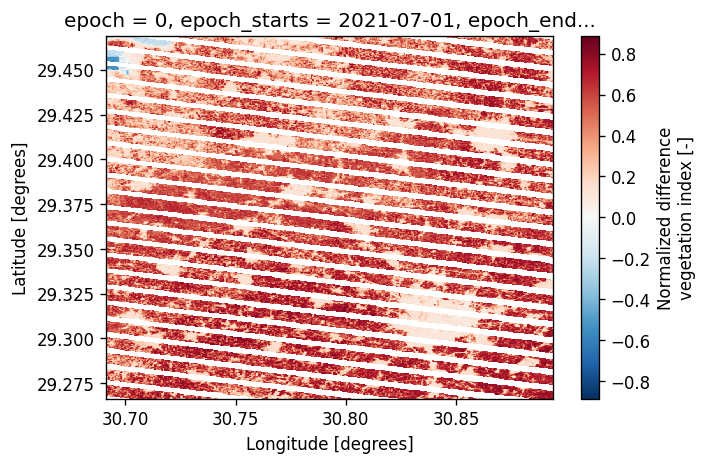

In [13]:
fig = plt.figure(1)
fig.set_dpi(120)
ds.ndvi.isel(lon = slice(1700, 2400), 
             lat = slice(800, 1500)).plot(ax = fig.gca())

The function we will create here, will use GDALs [fillnodata](https://gdal.org/programs/gdal_fillnodata.html) function. Every enhancement function we pass to `pre_et_look` needs to follow the following format.

In [14]:
def general_enhancement_function(ds, var, out_var = None):

    # Do your calculations here.
    new_data = xr.DataArray()

    if not isinstance(out_var, type(None)):
        ds[out_var] = new_data
    else: 
        ds[var] = new_data

    return ds

So, the function takes in the original `xr.Dataset` (i.e. `ds`), runs some calculations which create a new `xr.DataArray` (i.e. `new_data`) and finally puts that `new_data` back into the original `ds`, either overwriting the original `var` or adding a new variable (`out_var`), and returns it.

So what we need to do now is add some calculations to that template function.

In [15]:
import xarray as xr
import numpy as np
from osgeo import gdal

def gap_fill(ds, var, out_var = None, maxSearchDist = 3):

    # Create an empty xr.DataArray to store our results.
    new_data = xr.ones_like(ds[var]) * np.nan

    # Since gdal.FillNodata can only handle one band at a time, we have to loop over each scene.
    for t in ds.time:

        # Select the data at time t.
        da_slice = ds[var].sel(time = t)

        # Convert the data to a np.array with numeric no-data-value
        shape = da_slice.shape
        data = np.copy(da_slice.values)
        mask = np.isnan(data)
        ndv = -9999
        data[mask] = ndv

        # Create an in-memory gdal.Dataset.
        driver = gdal.GetDriverByName("MEM")
        gdal_ds = driver.Create('', shape[1], shape[0], 1, gdal.GDT_Float32)
        band = gdal_ds.GetRasterBand(1)
        band.SetNoDataValue(ndv)
        band.WriteArray(data)

        # Pass the gdal.Dataset to the gap filling algorithm.
        _ = gdal.FillNodata(targetBand = band, maskBand = None, 
                            maxSearchDist = maxSearchDist, smoothingIterations = 0)

        # Read the results and replace the no-data-values again.
        array = band.ReadAsArray()
        array[array == ndv] = np.nan

        # Release the gdal.Dataset.
        gdal_ds = gdal_ds.FlushCache()

        # Put the results back into the xr.DataArray.
        new_data = xr.where(new_data.time == t, array, new_data)

    if not isinstance(out_var, type(None)):
        ds[out_var] = new_data
    else: 
        ds[var] = new_data

    return ds

In [16]:
extra_source_enhancements = {("LS7", "ndvi"): [gap_fill]}

ds, fh = pywapor.pre_et_look.main(project_folder, startdate, enddate, 
                                    latlim, lonlim, level = my_custom_level, 
                                    extra_source_locations = extra_source_locations,
                                    extra_source_enhancements = extra_source_enhancements,
                                    process_vars = ["ndvi"])

> PRE_ET_LOOK
    # ndvi
    --> Collected 1 LS7 file(s).
    --> Resampling resolution is ~30 meter.
    --> Applying 'gap_fill' to `ndvi` from LS7.
    --> Resampling datasets.
    --> Calculating composites.
    > Composite enhancers.
    < Composite enhancers.
    --> Saving results.
< PRE_ET_LOOK


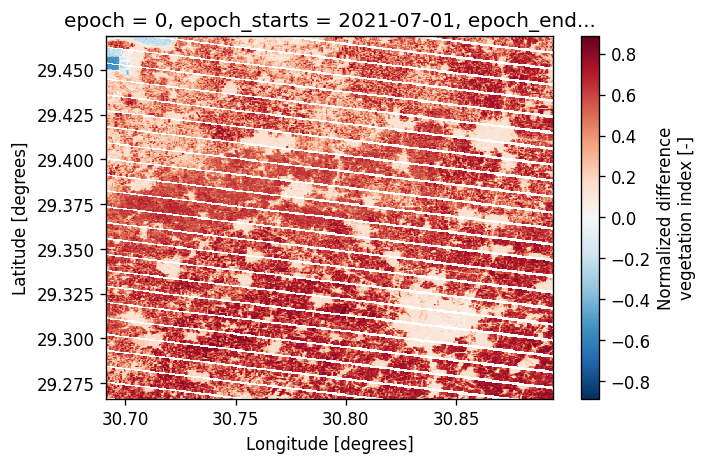

In [17]:
fig = plt.figure(1)
fig.set_dpi(120)
ds.ndvi.isel(lon = slice(1700, 2400), 
             lat = slice(800, 1500)).plot(ax = fig.gca())

As you can see, the lines of missing-data have become smaller, but didn't disappear completely. By increasing the `gdal.FillNodata` parameter called `maxSearchDist`, we can control how far the function will fill pixels. We can bind values to keyword arguments before handing the function over to `pre_et_look` like this. 

In [18]:
from functools import partial

extra_source_enhancements = {("LS7", "ndvi"): [partial(gap_fill, maxSearchDist = 6)]}

ds, fh = pywapor.pre_et_look.main(project_folder, startdate, enddate, 
                                    latlim, lonlim, level = my_custom_level, 
                                    extra_source_locations = extra_source_locations,
                                    extra_source_enhancements = extra_source_enhancements,
                                    process_vars = ["ndvi"])

> PRE_ET_LOOK
    # ndvi
    --> Collected 1 LS7 file(s).
    --> Resampling resolution is ~30 meter.
    --> Applying 'gap_fill' to `ndvi` from LS7.
    --> Resampling datasets.
    --> Calculating composites.
    > Composite enhancers.
    < Composite enhancers.
    --> Saving results.
< PRE_ET_LOOK


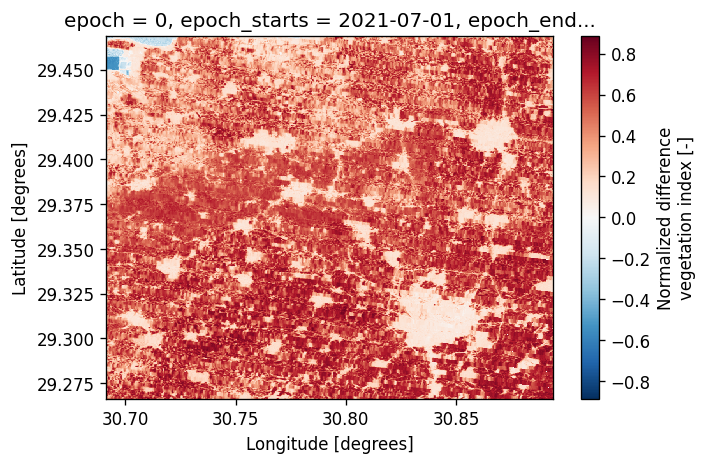

In [19]:
fig = plt.figure(1)
fig.set_dpi(120)
ds.ndvi.isel(lon = slice(1700, 2400), 
             lat = slice(800, 1500)).plot(ax = fig.gca())